In [ ]:
#Team Name - LearningtooDeep
#Team Members - Hashmmath Shaik, D Vivek Reddy, Satya Deep Dasari
#Net-Id - hs5544, vd2438, gd2576

#Importing Libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import numpy as np
import random
import matplotlib.pyplot as plt
import pickle
import csv
import torchvision

In [ ]:
# Setting a fixed seed for reproducibility across random number generators in Python, NumPy, and PyTorch (CPU/GPU), ensuring consistent results
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [ ]:
#Use GPU if available
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Using device:", device)

Using device: cuda


In [ ]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        # First convolutional layer
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)

        # Second convolutional layer
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        # Shortcut connection if dimensions change
        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes * self.expansion:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes * self.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * self.expansion)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        return F.relu(out)

class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 32

        # Initial convolution
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(32)

        # Creating each ResNet layer
        self.layer1 = self._make_layer(block, 32, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 64, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 128, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 256, num_blocks[3], stride=2)

        # Pooling and classification
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(256 * block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks - 1)
        layers = []
        for s in strides:
            layers.append(block(self.in_planes, planes, s))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avgpool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

def ResNetSmall():
    return ResNet(BasicBlock, [4, 4, 4, 3], num_classes=10)

# Explanation:
# This code defines a customizable ResNet architecture using BasicBlocks for learning features from images.
# It sets up a convolutional neural network that applies multiple layers of filters and integrates shortcuts to
# facilitate deeper architectures without losing information through propagation. This setup is ideal for tasks
# like image classification where hierarchical feature extraction is beneficial. The `ResNetSmall` function
# provides an easy way to instantiate a smaller version of the ResNet with predefined layer configurations.


In [ ]:
# Instantiate the ResNet model for small-scale applications
model = ResNetSmall().to(device)
# Calculating the total number of trainable parameters in the model
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Model param count: {num_params:,}")  # Display the parameter count

# Importing torchsummary for detailed model architecture visualization
from torchsummary import summary
# Providing a summary of the model with expected input dimensions
summary(model, input_size=(3, 32, 32))  # For CIFAR-10 dataset dimension compatibility

# Explanation:
# This code initializes a ResNet model designed for handling smaller datasets (like CIFAR-10) and
# moves it to the appropriate computation device (GPU or CPU). It calculates and displays the total
# number of trainable parameters, offering an insight into the model’s complexity. Using `torchsummary`,
# it then prints a detailed summary of the model, showing each layer’s output shape and the number of
# parameters, which helps in understanding the data flow and resource allocation within the network.


Model param count: 4,754,218
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             864
       BatchNorm2d-2           [-1, 32, 32, 32]              64
            Conv2d-3           [-1, 32, 32, 32]           9,216
       BatchNorm2d-4           [-1, 32, 32, 32]              64
            Conv2d-5           [-1, 32, 32, 32]           9,216
       BatchNorm2d-6           [-1, 32, 32, 32]              64
        BasicBlock-7           [-1, 32, 32, 32]               0
            Conv2d-8           [-1, 32, 32, 32]           9,216
       BatchNorm2d-9           [-1, 32, 32, 32]              64
           Conv2d-10           [-1, 32, 32, 32]           9,216
      BatchNorm2d-11           [-1, 32, 32, 32]              64
       BasicBlock-12           [-1, 32, 32, 32]               0
           Conv2d-13           [-1, 32, 32, 32]           9,216
      Batc

In [ ]:
# Defining normalization constants for the CIFAR-10 dataset
MEAN = [0.4914, 0.4822, 0.4465]
STD  = [0.2023, 0.1994, 0.2010]

# Data augmentation and normalization for training data
train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),  # Applying random cropping to images
    transforms.RandomHorizontalFlip(),     # Randomly flipping images horizontally
    transforms.ToTensor(),                 # Converting image data to PyTorch tensors
    transforms.Normalize(MEAN, STD),       # Normalizing the tensor images
])

# Normalization without augmentation for testing data
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(MEAN, STD),
])

# Loading CIFAR-10 training dataset with applied transformations
train_dataset = datasets.CIFAR10(root="./data", train=True, download=True, transform=train_transform)
# Loading CIFAR-10 testing dataset with applied transformations
test_dataset = datasets.CIFAR10(root="./data", train=False, download=True, transform=test_transform)

# Creating DataLoaders to handle batching, shuffling, and parallel loading
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True,  num_workers=2)
test_loader  = DataLoader(test_dataset,  batch_size=128, shuffle=False, num_workers=2)

# Explanation:
# This code sets up the data preprocessing for the CIFAR-10 dataset, which includes normalization
# and data augmentation (for training data) to improve model generalizability. It then loads the
# CIFAR-10 datasets with these transformations and sets up DataLoaders for efficiently feeding
# the data into a neural network during training and testing. This setup is crucial for handling
# images in deep learning tasks, ensuring that the input data is in a suitable form for the model
# to process effectively.


100%|██████████| 170M/170M [00:04<00:00, 40.7MB/s]


In [ ]:
# Defining a function to train the model for one epoch
def train(model, loader, optimizer, criterion):
    model.train()  # Setting the model to training mode which enables dropout layers and batch normalization
    running_loss = 0.0
    correct = 0
    total = 0

    for imgs, labels in loader:  # Looping through the training data
        imgs, labels = imgs.to(device), labels.to(device)  # Transfering images and labels to the device (GPU or CPU)

        optimizer.zero_grad()  # Clearing gradients from the previous iteration
        outputs = model(imgs)  # Computing the model output
        loss = criterion(outputs, labels)  # Calculating loss between output and ground truth labels
        loss.backward()  # Backpropagating the loss
        optimizer.step()  # Adjusting model weights based on the computed gradients

        running_loss += loss.item() * imgs.size(0)  # Updating total loss
        _, pred = outputs.max(1)  # Determining predicted labels by selecting the max value in the output tensor
        correct += pred.eq(labels).sum().item()  # Counting how many predictions were correct
        total += labels.size(0)  # Incrementing the total count of items

    epoch_loss = running_loss / total  # Calculating average loss for the epoch
    epoch_acc = 100.0 * correct / total  # Calculating accuracy as a percentage
    return epoch_loss, epoch_acc  # Returning the average loss and accuracy for the epoch

# Defining a function to evaluate the model on the validation/test dataset
def evaluate(model, loader, criterion):
    model.eval()  # Setting the model to evaluation mode, which disables dropout and batch normalization
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():  # Context-manager that disables gradient calculation; useful for inference
        for imgs, labels in loader:
            imgs, labels = imgs.to(device), labels.to(device)  # Transfering images and labels to the device

            outputs = model(imgs)  # Computing the model output
            loss = criterion(outputs, labels)  # Calculating the loss
            running_loss += loss.item() * imgs.size(0)  # Updating total loss
            _, pred = outputs.max(1)  # Determining predicted labels
            correct += pred.eq(labels).sum().item()  # Counting how many predictions were correct
            total += labels.size(0)  # Incrementing the total count of items

    epoch_loss = running_loss / total  # Calculating average loss for the epoch
    epoch_acc = 100.0 * correct / total  # Calculating accuracy as a percentage
    return epoch_loss, epoch_acc  # Returning the average loss and accuracy for the epoch

# In this code the train function trains the model for one epoch by iterating over the training dataset, 
# computing predictions, calculating the loss using a specified criterion, performing backpropagation, 
# and updating the model weights using an optimizer. It tracks total loss and accuracy, returning them 
# at the end. The evaluate function assesses model performance on a validation or test set by disabling 
# gradient calculations, computing predictions, calculating loss, and measuring accuracy without 
# updating weights. Both functions operate on mini-batches of data, transferring tensors to the 
# specified device (CPU/GPU), and ensure correct training behaviors by toggling between training and 
# evaluation modes. These functions are crucial for supervised deep learning workflows.

In [ ]:
# Defining the loss function and optimizer with hyperparameters
criterion = nn.CrossEntropyLoss()  # Loss function for classification
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)  # Stochastic gradient descent with momentum
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[50, 75], gamma=0.1)  # Learning rate scheduler

# Explanation:
# This setup configures the neural network for training by establishing a loss function suited for multi-class
# classification problems. It employs an SGD optimizer with momentum to stabilize updates and improve convergence.
# The learning rate scheduler is configured to reduce the learning rate at specified epochs (50 and 75),
# which helps in fine-tuning t


In [ ]:
# Initializing lists to track training and validation metrics
train_losses = []
train_accs = []
val_losses = []
val_accs = []

EPOCHS = 100  # Number of training cycles
best_acc = 0.0  # Best observed accuracy

# Training loop
for epoch in range(EPOCHS):
    train_loss, train_acc = train(model, train_loader, optimizer, criterion)  # Training model
    val_loss, val_acc = evaluate(model, test_loader, criterion)  # Evaluating model
    scheduler.step()  # Adjusting learning rate

    # Saving the model if validation accuracy improves
    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), "best_model_ResNet.pth")  # Saving model parameters

    # Printing training and validation results for the epoch
    print(f"Epoch [{epoch+1:03d}/{EPOCHS}] "
          f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% || "
          f"Test Loss: {val_loss:.4f} | Test Acc: {val_acc:.2f}%")

print("\nTraining complete!")
print(f"Best Test Accuracy: {best_acc:.2f}%")

# Explanation:
# This code manages the training process of a deep learning model over a specified number of epochs. It performs
# training and validation at each epoch, tracking loss and accuracy metrics to monitor the model's performance.
# The learning rate scheduler adjusts the training parameters dynamically, and the model state is saved whenever
# there is an improvement in validation accuracy. This ensures that the best performing model is retained.
# The routine is designed to provide detailed feedback on the model's performance throughout the training process,
# allowing for real-time monitoring and optimization of model training.


Epoch [001/100] Train Loss: 1.9422 | Train Acc: 28.70% || Test Loss: 1.5954 | Test Acc: 40.75%
Epoch [002/100] Train Loss: 1.5180 | Train Acc: 44.13% || Test Loss: 1.3548 | Test Acc: 50.09%
Epoch [003/100] Train Loss: 1.2712 | Train Acc: 53.95% || Test Loss: 1.2053 | Test Acc: 55.90%
Epoch [004/100] Train Loss: 1.0472 | Train Acc: 62.67% || Test Loss: 0.9936 | Test Acc: 65.64%
Epoch [005/100] Train Loss: 0.8574 | Train Acc: 69.81% || Test Loss: 0.9822 | Test Acc: 67.39%
Epoch [006/100] Train Loss: 0.7373 | Train Acc: 74.36% || Test Loss: 1.0911 | Test Acc: 64.74%
Epoch [007/100] Train Loss: 0.6634 | Train Acc: 76.98% || Test Loss: 0.8343 | Test Acc: 72.61%
Epoch [008/100] Train Loss: 0.6226 | Train Acc: 78.53% || Test Loss: 0.7018 | Test Acc: 75.60%
Epoch [009/100] Train Loss: 0.5763 | Train Acc: 80.13% || Test Loss: 0.6970 | Test Acc: 76.70%
Epoch [010/100] Train Loss: 0.5562 | Train Acc: 80.74% || Test Loss: 0.6531 | Test Acc: 77.21%
Epoch [011/100] Train Loss: 0.5348 | Train Acc: 81

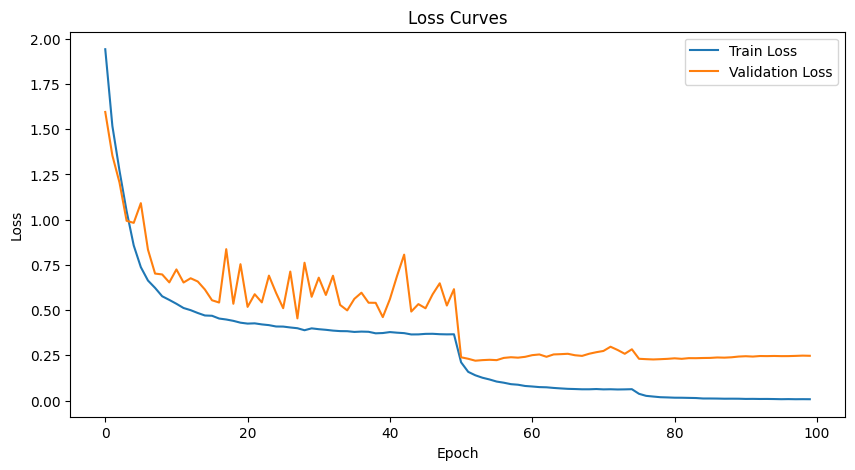

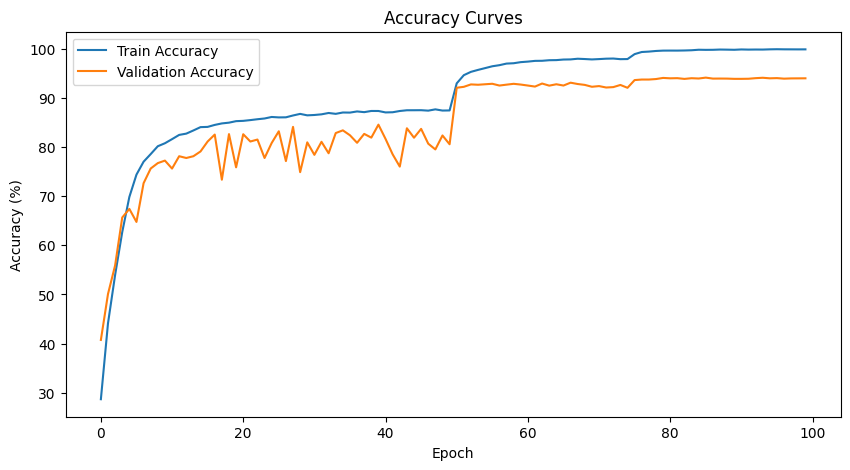

In [ ]:
import matplotlib.pyplot as plt

# Plotting loss curves for both training and validation phases
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Train Loss")  # Plotting training loss
plt.plot(val_losses, label="Validation Loss")  # Plotting validation loss
plt.title("Loss Curves")  # Title of the plot
plt.xlabel("Epoch")  # X-axis label
plt.ylabel("Loss")  # Y-axis label
plt.legend()  # Including a legend
plt.show()  # Displaying the plot

# Plotting accuracy curves for both training and validation phases
plt.figure(figsize=(10, 5))
plt.plot(train_accs, label="Train Accuracy")  # Plotting training accuracy
plt.plot(val_accs, label="Validation Accuracy")  # Plotting validation accuracy
plt.title("Accuracy Curves")  # Title of the plot
plt.xlabel("Epoch")  # X-axis label
plt.ylabel("Accuracy (%)")  # Y-axis label
plt.legend()  # Including a legend
plt.show()  # Displaying the plot

# Explanation:
# This code visualizes the progress of the neural network training and validation phases over multiple epochs,
# using loss and accuracy as metrics. The loss plots help in understanding how well the model is minimizing the
# error over time, while the accuracy plots provide insights into the model's performance in classifying the data correctly.
# These visualizations are crucial for diagnosing training behavior, such as detecting overfitting or underfitting,
# and making informed decisions about potential adjustments in learning rate or other hyperparameters.


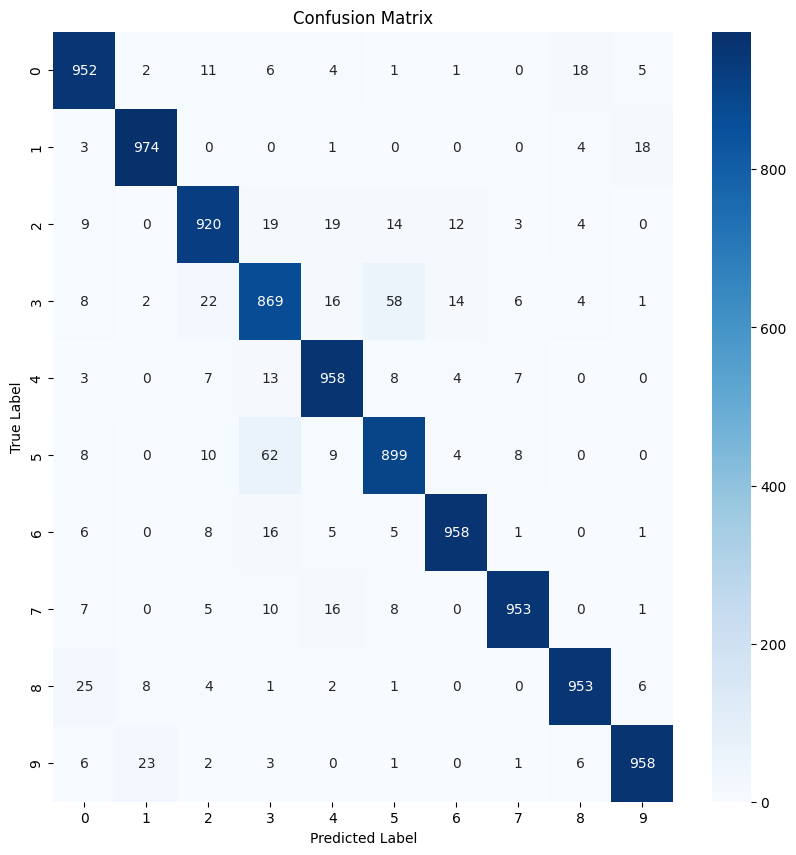

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Obtaining predictions for the test set
all_preds = []
all_labels = []
with torch.no_grad():  # Disabling gradient computation
    for imgs, labels in test_loader:
        imgs, labels = imgs.to(device), labels.to(device)  # Moving data to the appropriate device
        outputs = model(imgs)  # Getting model outputs
        _, preds = torch.max(outputs, 1)  # Determining predicted classes
        all_preds.extend(preds.cpu().numpy())  # Storing predictions
        all_labels.extend(labels.cpu().numpy())  # Storing true labels

# Computing the confusion matrix using true and predicted labels
cm = confusion_matrix(all_labels, all_preds)

# Visualizing the confusion matrix using seaborn's heatmap
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")  # Annotate cells with integer formatting
plt.title("Confusion Matrix")  # Title of the plot
plt.xlabel("Predicted Label")  # X-axis label
plt.ylabel("True Label")  # Y-axis label
plt.show()  # Displaying the plot

# Explanation:
# This code is used for evaluating the classification performance of a neural network by generating a confusion matrix,
# which provides a visualization of the accuracy of predictions across all classes. The confusion matrix is a useful tool to
# see the model's performance in terms of false positives, false negatives, true positives, and true negatives for each class.
# This helps in identifying classes that are well-classified versus those that the model confuses with others.


In [ ]:
from PIL import ImageFilter
import random
import torchvision
from torch.utils.data import DataLoader
from torchvision import transforms

# Custom Gaussian blur function
def gaussian_blur(img):
    radius = random.uniform(0.1, 1.5)  # Choosing a random blur radius
    return img.filter(ImageFilter.GaussianBlur(radius))

# Defining data augmentation and preprocessing for training images
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),  # Cropping images with padding
    transforms.RandomHorizontalFlip(),     # Randomly flipping images horizontally
    transforms.RandomApply([               # Applying Gaussian blur randomly
        transforms.Lambda(gaussian_blur)
    ], p=0.3),
    transforms.RandomVerticalFlip(p=0.05),  # Randomly flipping images vertically with a small probability
    transforms.ToTensor(),                  # Converting images to PyTorch tensors
    transforms.Normalize((0.4914, 0.4822, 0.4465),  # Normalizing images
                         (0.2470, 0.2435, 0.2616)),
    transforms.RandomErasing(p=0.5, scale=(0.02, 0.2))  # Randomly erasing parts of the image
])

# Loading CIFAR-10 training dataset with the defined transformations
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=2)

# Explanation:
# This code sets up a data preprocessing pipeline for the CIFAR-10 training dataset, integrating several
# data augmentation techniques to enhance model generalization. These include random crops, flips, Gaussian
# blur, and random erasing. Each technique introduces variability in the training data, making the model
# more robust to different visual variations it might encounter, thus improving its ability to generalize
# from the training data to unseen data.


In [ ]:
# CutMix implementation
def cutmix_data(x, y, alpha=1.0):
    batch_size = x.size(0)
    index = torch.randperm(batch_size).to(device)

    # Sample from beta distribution
    lam = np.random.beta(alpha, alpha)

    # Defining the bounding box coordinates
    bbx1, bby1, bbx2, bby2 = rand_bbox(x.size(), lam)

    # Performing CutMix
    x[:, :, bbx1:bbx2, bby1:bby2] = x[index, :, bbx1:bbx2, bby1:bby2]

    # Adjusting lambda to exactly match pixel ratio
    lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (x.size()[-1] * x.size()[-2]))

    # Creating mixed target
    y_a, y_b = y, y[index]

    return x, y_a, y_b, lam

def rand_bbox(size, lam):
    W = size[2]
    H = size[3]
    cut_rat = np.sqrt(1. - lam)
    cut_w = int(W * cut_rat)
    cut_h = int(H * cut_rat)

    # Uniform
    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)

    return bbx1, bby1, bbx2, bby2

# This code contains CutMix implementation augments training data by mixing images and labels to enhance 
# model generalization. The `cutmix_data` function randomly selects a portion of an image and replaces 
# it with a corresponding region from another randomly chosen image in the batch, determined by a 
# sampled lambda value from a Beta distribution. It also adjusts lambda to match the exact pixel ratio 
# and returns mixed images along with their original and mixed labels. The `rand_bbox` function 
# calculates the bounding box coordinates for the region to be replaced based on the sampled lambda 
# value, ensuring randomized but controlled mixing of image patches.


In [ ]:
num_epochs = 100  # Total number of training epochs
learning_rate = 0.01  # Initial learning rate
momentum = 0.9  # Momentum factor for SGD optimizer
weight_decay = 5e-4  # Regularization to prevent overfitting
batch_size = 128  # Number of samples per batch during training

criterion = nn.CrossEntropyLoss()  # Loss function for multi-class classification
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum, weight_decay=weight_decay)  # Stochastic Gradient Descent

# Learning rate scheduler to gradually reduce learning rate for better convergence
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

# Training loop
for epoch in range(num_epochs):
    train_loss, train_acc = train(model, train_loader, optimizer, criterion)  # Training the model
    val_loss, val_acc = evaluate(model, test_loader, criterion)  # Evaluating on validation set
    scheduler.step()  # Updating learning rate based on Cosine Annealing schedule

    # Printing training progress per epoch
    print(f"Epoch [{epoch+1}/{num_epochs}] LR: {optimizer.param_groups[0]['lr']:.6f}, "
          f"Train Loss: {train_loss:.4f}, Test Acc: {val_acc:.2f}%")

# Explanation:
# This code defines and executes the model training process for 100 epochs using the Stochastic Gradient Descent (SGD) optimizer.
# A learning rate scheduler, Cosine Annealing, is used to dynamically adjust the learning rate over epochs for improved convergence.
# The training process iterates over multiple epochs, where each epoch consists of:
# 1. Training the model on the training dataset.
# 2. Evaluating the model on the validation dataset.
# 3. Updating the learning rate based on the scheduler.
# The training progress, including the learning rate, loss, and accuracy, is printed after each epoch to track the model's performance.


Epoch [1/100] LR: 0.009998, Train Loss: 0.4110, Test Acc: 89.47%
Epoch [2/100] LR: 0.009990, Train Loss: 0.3192, Test Acc: 91.05%
Epoch [3/100] LR: 0.009978, Train Loss: 0.3043, Test Acc: 90.43%
Epoch [4/100] LR: 0.009961, Train Loss: 0.2869, Test Acc: 90.26%
Epoch [5/100] LR: 0.009938, Train Loss: 0.2813, Test Acc: 91.11%
Epoch [6/100] LR: 0.009911, Train Loss: 0.2711, Test Acc: 91.30%
Epoch [7/100] LR: 0.009880, Train Loss: 0.2665, Test Acc: 90.96%
Epoch [8/100] LR: 0.009843, Train Loss: 0.2664, Test Acc: 91.08%
Epoch [9/100] LR: 0.009801, Train Loss: 0.2566, Test Acc: 91.26%
Epoch [10/100] LR: 0.009755, Train Loss: 0.2534, Test Acc: 91.11%
Epoch [11/100] LR: 0.009704, Train Loss: 0.2513, Test Acc: 90.55%
Epoch [12/100] LR: 0.009649, Train Loss: 0.2449, Test Acc: 91.28%
Epoch [13/100] LR: 0.009589, Train Loss: 0.2470, Test Acc: 91.51%
Epoch [14/100] LR: 0.009524, Train Loss: 0.2403, Test Acc: 91.30%
Epoch [15/100] LR: 0.009455, Train Loss: 0.2338, Test Acc: 91.79%
Epoch [16/100] LR: 

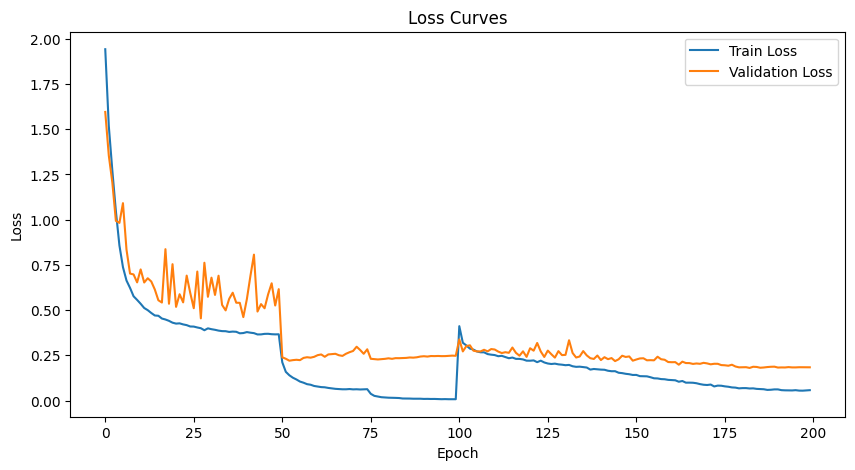

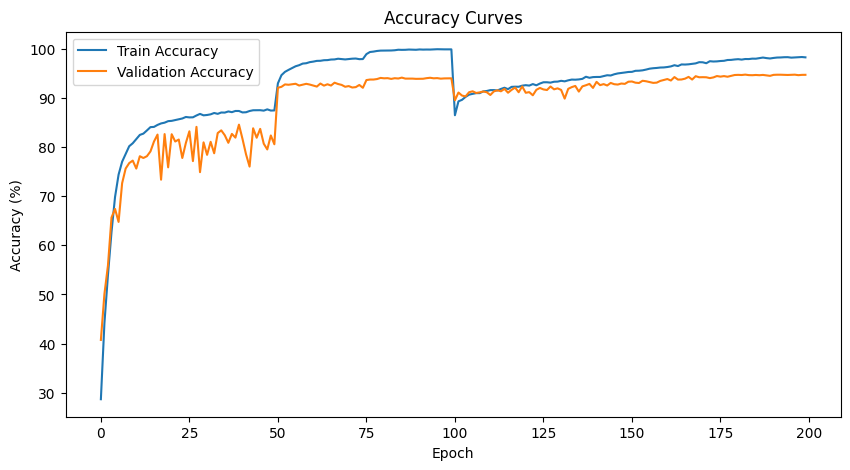

In [ ]:
import matplotlib.pyplot as plt

# Plotting loss curves to visualize how the model's loss changes over epochs
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.title("Loss Curves")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Plotting accuracy curves to track how well the model is learning over time
plt.figure(figsize=(10, 5))
plt.plot(train_accs, label="Train Accuracy")
plt.plot(val_accs, label="Validation Accuracy")
plt.title("Accuracy Curves")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.show()

# Explanation:
# This code generates two plots: one for loss curves and one for accuracy curves.
# The loss curves help to observe whether the model's training loss is decreasing and if validation loss stabilizes.
# The accuracy curves show the percentage of correctly classified samples over time, allowing us to assess whether
# the model is improving or overfitting. These plots are useful for diagnosing issues such as underfitting or overfitting.


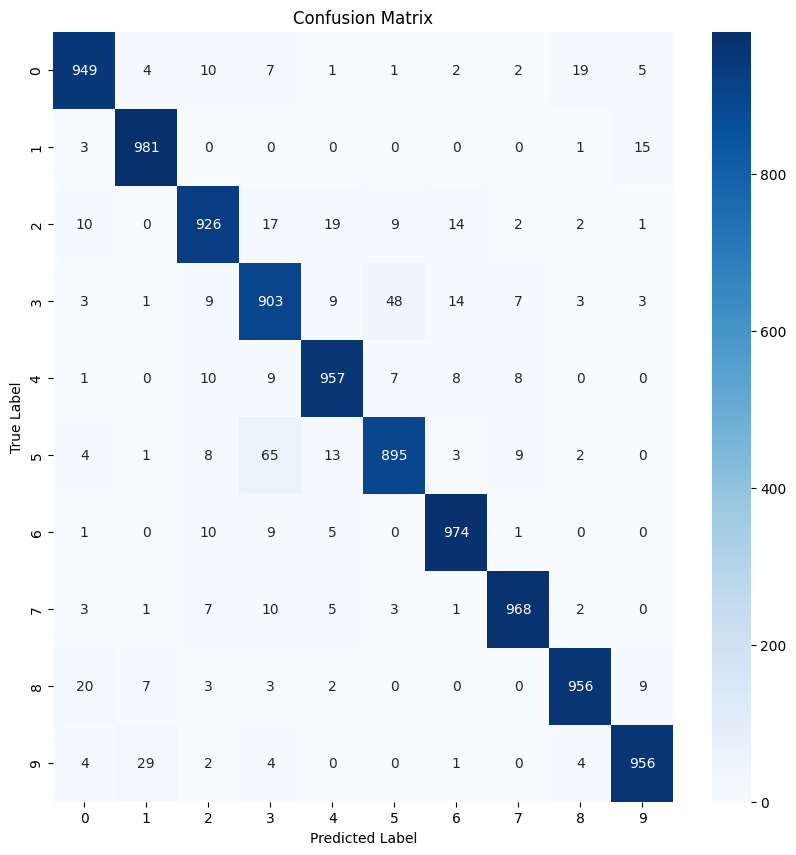

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Collecting model predictions and true labels for the test set
all_preds = []
all_labels = []
with torch.no_grad():  # Disabling gradient calculation for evaluation
    for imgs, labels in test_loader:
        imgs, labels = imgs.to(device), labels.to(device)  # Move data to device
        outputs = model(imgs)
        _, preds = torch.max(outputs, 1)  # Getting predicted class labels
        all_preds.extend(preds.cpu().numpy())  # Converting to numpy and store
        all_labels.extend(labels.cpu().numpy())  # Converting to numpy and store

# Generating confusion matrix to compare predicted vs actual labels
cm = confusion_matrix(all_labels, all_preds)

# Visualizing the confusion matrix
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")  # Heatmap with annotations
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Explanation:
# This code evaluates the model's performance by creating a confusion matrix, which shows the number of times
# each class was correctly or incorrectly predicted. This is particularly useful for identifying which classes
# the model struggles with. The seaborn heatmap visually represents the confusion matrix, making it easier to
# interpret misclassifications. This helps in diagnosing model weaknesses and improving training strategies.


In [ ]:
import torch
import pickle
import csv
import numpy as np
from torchvision import transforms
from PIL import Image

# Defining mean and standard deviation used during training for normalization
MEAN = [0.4914, 0.4822, 0.4465]
STD = [0.2470, 0.2435, 0.2616]

# Setting device to GPU if available, else use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Path to the custom test dataset
custom_test_path = "/content/cifar_test_nolabel.pkl"

# Function to apply Gaussian blur (used for Test Time Augmentation)
def gaussian_blur(img):
    from scipy.ndimage import gaussian_filter
    img_np = np.array(img)
    blurred = gaussian_filter(img_np, sigma=1.0)
    return Image.fromarray(blurred.astype(np.uint8))

# Defining various Test Time Augmentation (TTA) transformations
tta_transforms = [
    transforms.ToTensor(),  # Base transformation without augmentation
    transforms.Compose([transforms.RandomHorizontalFlip(p=1.0), transforms.ToTensor()]),  # Flipping horizontally
    transforms.Compose([transforms.Pad(4), transforms.CenterCrop(32), transforms.ToTensor()]),  # Center crop
    transforms.Compose([transforms.Lambda(gaussian_blur), transforms.ToTensor()]),  # Applying Gaussian blur
    transforms.Compose([transforms.RandomVerticalFlip(p=1.0), transforms.ToTensor()]),  # Flipping vertically
]

# Function to normalize and format an image for model input
def custom_transform(img_np):
    if img_np.shape == (3*32*32,):
        img_np = img_np.reshape(3,32,32).transpose(1,2,0)  # Reshaping if necessary
    img_np = img_np.transpose(2,0,1)  # Converting to CHW format
    tensor_img = torch.from_numpy(img_np).float() / 255.0  # Converting to tensor and scale
    for i in range(3):  # Applying normalization
        tensor_img[i,:,:] = (tensor_img[i,:,:] - MEAN[i]) / STD[i]
    return tensor_img

# Loading the custom test dataset and generate predictions using TTA
try:
    with open(custom_test_path, 'rb') as f:
        custom_test_data = pickle.load(f)

    unlabeled_imgs = custom_test_data[b'data']
    unlabeled_ids = custom_test_data[b'ids']

    model.eval()  # Set model to evaluation mode
    predictions = []

    with torch.no_grad():  # Disabling gradient computation
        for i in range(len(unlabeled_imgs)):
            img_np = unlabeled_imgs[i]
            if img_np.shape == (3*32*32,):
                img_np = img_np.reshape(3,32,32).transpose(1,2,0)
            img_np = img_np.astype(np.uint8)  # Converting to uint8 for PIL compatibility

            # Storing predictions from all augmentations
            tta_outputs = []

            # Applying each Test Time Augmentation transformation
            for tta_transform in tta_transforms:
                img_pil = Image.fromarray(img_np)  # Converting to PIL image
                aug_img = tta_transform(img_pil)  # Applying transformation

                # Applying normalization
                for j in range(3):
                    aug_img[j,:,:] = (aug_img[j,:,:] - MEAN[j]) / STD[j]

                aug_img = aug_img.unsqueeze(0).to(device)  # Adding batch dimension
                output = model(aug_img)  # Getting model prediction
                tta_outputs.append(output)

            # Averaging predictions across all augmentations
            avg_output = torch.mean(torch.stack(tta_outputs), dim=0)
            _, pred_label = torch.max(avg_output, 1)  # Getting final predicted label
            predictions.append((unlabeled_ids[i], pred_label.item()))

    # Writing predictions to CSV file
    csv_filename = "DL.csv"
    with open(csv_filename, 'w', newline='') as csv_file:
        writer = csv.writer(csv_file)
        writer.writerow(["ID", "Labels"])  
        for (img_id, label) in predictions:
            writer.writerow([img_id, label])  

    print(f"CSV saved as '{csv_filename}' with {len(predictions)} entries.")

except Exception as e:
    print(f"An error occurred: {str(e)}")

# Explanation:
# This code loads a custom test dataset (CIFAR test images without labels), applies Test Time Augmentation (TTA),
# and generates predictions for each image using an already trained model.
# TTA improves model robustness by applying different augmentations like flipping, cropping, and Gaussian blur.
# Predictions from multiple transformations are averaged to produce a final prediction for each image.
# The predicted labels are saved in a CSV file, formatted correctly for submission.


CSV saved as 'DL.csv' with 10000 entries.
